In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from numba import jit, cuda

some notes:
change the seed for the random number and try fitting the data multiple times



In [2]:
def create_spatial_grid(stim_ecc, gridsize):
    """This function samples the visual space for a given eccentricity coverage and gridsize.
    The x and y coordinate outputs arethen used for creating the pRF parameters (see create_prf_params function).
    NMA is strictly implemented for a formulated space, so the model will only work
    if the receptive fields are defined within the same grid as the input stimulus. """

    coord = np.sqrt(((stim_ecc)**2)/2)
    x_coordinates = torch.linspace(-coord, coord, gridsize)
    y_coordinates = torch.linspace(coord, -coord, gridsize)
    y_grid, x_grid = torch.meshgrid(x_coordinates, y_coordinates)
    y_grid = -1*y_grid
    x_grid = -1*x_grid
    return x_coordinates, y_coordinates, x_grid, y_grid


In [3]:
def prepare_stimulus(stim, gridsize):
    """This function uses 1D interpolation across columns and rows separately, and resizes the original 
    stimulus input to the desired grid size"""    
    old_dim, new_dim = stim.shape[0], gridsize
    col_im = np.zeros((new_dim,old_dim))
    stim_reshaped = np.zeros((new_dim,new_dim,stimorig.shape[2]))
    nls, ols = np.linspace(0, 1, new_dim), np.linspace(0,1,old_dim)

    for stim_idx in range(0, stimorig.shape[2]):
        for col in range(old_dim):
            col_im[:,col] = np.interp(nls,ols,stimorig[:,col,stim_idx])
        for col in range(new_dim):
            stim_reshaped[col,:, stim_idx] = np.interp(nls,ols,col_im[col,:])
    
    stim_reshaped = torch.from_numpy(stim_reshaped)
    stim_reshaped = stim_reshaped.to(torch.float32)
    
    return stim_reshaped



In [4]:
def create_prf_centers_torch(x_coordinates, y_coordinates):
    """Combines each element of x coordinates with y coordinates to tile the visual
    field"""
    
    prf_parameters = np.zeros((2,len(x_coordinates)*len(y_coordinates)))
    iter_idx = 0
    
    for i in range(0,len(y_coordinates)):
        for j in range(0,len(x_coordinates)):
            prf_parameters[0,iter_idx] = x_coordinates[j] 
            prf_parameters[1,iter_idx] = y_coordinates[i]
            iter_idx = iter_idx + 1 

    prf_parameters = torch.from_numpy(prf_parameters)
    
    return prf_parameters[0,:], prf_parameters[1,:]



In [5]:
def create_gaussian_field(x_grid, y_grid, x, y, sigma, type = None, normalize= True, flat = True):
    """Creates a 2D Gaussian for the given X and Y center and the sigma factor.
    Has the option to 1) normalize the Gaussian field to the unit volume and 
    2) flatten the Gaussian (vectorize it)"""

    gaussian = torch.exp(-((x_grid-x)**2 +(y_grid-y)**2)/(2*sigma)**2)

    if type == 'euclidean_distance':
        distance = torch.sqrt((x_grid-x)**2+(y_grid-y)**2)
        gaussian = torch.exp(-.5*(distance/sigma)**2)
    if normalize: 
        gaussian = gaussian/torch.linalg.norm(gaussian)
    if flat:
        gaussian = gaussian.flatten()


    gaussian = gaussian.to(torch.float32)
    
    return gaussian


In [6]:
def interpolate_voxel_center(x_grid, y_grid, voxeldata):

    voxel_lookup_indices = torch.empty(voxeldata.shape[1], dtype=torch.long)
    distance_vector = torch.empty((len(x_grid)*len(y_grid),voxeldata.shape[1]))
    x_grid = x_grid.flatten()
    y_grid = y_grid.flatten()

    for idx in range(0,voxeldata.shape[1]):
        distance_vector[:,idx] = torch.sqrt((voxeldata[0, idx] - x_grid)**2 + (voxeldata[1, idx] - y_grid)**2)
        voxel_lookup_indices[idx] = torch.argmin(torch.abs(distance_vector[:,idx]))

    return distance_vector, voxel_lookup_indices

In [7]:
class NormalizationModelofAttention(torch.nn.Module):
    def __init__(self, normalization_sigma, voxeldata, attention_ctr, stim_ecc=10, prf_sigma_scale_factor = None,
                 attention_field_sigma = None,
                 attention_field_gain = None,
                 suppressive_surround_sigma_factor = None,
                 summation_field_sigma_factor = None):
        """
        The model is initialized using the X and Y coordinates of the estimated pRFs for each voxel,
        total number of voxels (this can be indexed on the first input), grid size (this will depend on how precise
        we want to get?), stimulys eccentricity (max) and the X and Y coordinates of attention field
        """
        super().__init__() #super() alone returns a temporary object of the superclass that then allows you to call that superclass’s methods.
        self.gridsize = 64
        x_coordinates, y_coordinates, self.X, self.Y = create_spatial_grid(stim_ecc, self.gridsize)
        self.distance_vector, self.voxel_lookup_indices = interpolate_voxel_center(self.X, self.Y, voxeldata)
        self.RF_X, self.RF_Y = create_prf_centers_torch(x_coordinates, y_coordinates)
        self.attention_ctr = attention_ctr
        self.ROI_normalization_sigma_factor = normalization_sigma
        self.voxel_gain = torch.ones((1, len(self.RF_X)), dtype = torch.float32)

        for k in ['prf_sigma_scale_factor', 'attention_field_sigma', 'attention_field_gain', 'suppressive_surround_sigma_factor', 'summation_field_sigma_factor']:
            v = eval(k)
            if v is not None:
                setattr(self, k, torch.nn.Parameter(torch.tensor(v, dtype=torch.float32)))
                print('Parameter %s is set to %f' %(k, v))
            else:
                setattr(self, k, torch.nn.Parameter(torch.rand(1, dtype=torch.float32)))

    def forward(self, stim):
        """
        Predicts the estimates of BOLD activity for a given input stimulus based on the normalization model of attention.
        """
        if stim.ndim != 3:
            stim = stim.unsqueeze(1)
            print("Stimulus is unsqueezed over the third dimension")

        ##### PREALLOCATE #####
        receptive_field = torch.empty((self.gridsize, self.gridsize , self.gridsize *self.gridsize ))
        suppressive_surround = torch.empty((self.gridsize *self.gridsize , self.gridsize *self.gridsize ))
        summation_field = torch.empty((self.gridsize *self.gridsize , self.gridsize *self.gridsize ))
        ##### PREALLOCATE #####


        attfield = create_gaussian_field(self.X, self.Y, self.attention_ctr[0], self.attention_ctr[1], self.attention_field_sigma, None, False, True)
        attfield =  self.attention_field_gain * attfield + 1


        rf_sigma =  0.07 + self.prf_sigma_scale_factor * (torch.sqrt(self.RF_X**2 +  self.RF_Y**2))
        rf_supp_sigma = rf_sigma * self.suppressive_surround_sigma_factor
        rf_summ_sigma =  rf_sigma * self.summation_field_sigma_factor


        for rf in range(0, self.gridsize  * self.gridsize ):
            receptive_field[...,rf]        = create_gaussian_field(self.X,self.Y,self.RF_X[rf],self.RF_Y[rf],rf_sigma[rf], None, True, False)
            suppressive_surround[...,rf]   = create_gaussian_field(self.X,self.Y,self.RF_X[rf],self.RF_Y[rf],rf_supp_sigma[rf], 'euclidean_distance', True, True)
            summation_field[...,rf]        = create_gaussian_field(self.X,self.Y,self.RF_X[rf],self.RF_Y[rf],rf_summ_sigma[rf], 'euclidean_distance', True, True)

        ######
        stimdrive        = torch.einsum('ijk,ija->ka', receptive_field, stim)
        numerator        = torch.einsum('ij,i->ij', stimdrive, attfield)
        surroundresponse =  torch.einsum('wr,rs->ws', suppressive_surround.T, numerator)

        #denominator = torch.clip(surroundresponse +  self.ROI_normalization_sigma_factor, 1e-6)
        # if surroundresponse +  self.ROI_normalization_sigma_factor < 1e-6:
        #    print("Clipping the denominator (original value: %f)" %(surroundresponse +  self.ROI_normalization_sigma_factor))

        predneuralweights = numerator / (surroundresponse + self.ROI_normalization_sigma_factor)

        spsummedresponse =  torch.einsum('wr,rs->ws', summation_field.T, predneuralweights)
        predicted_neural_response = predneuralweights[self.voxel_lookup_indices]
        predicted_voxel_response = spsummedresponse[self.voxel_lookup_indices]

        return predicted_voxel_response

Now define the objective function to optimize the beta weights predicted by normalization model. It *feels* like it will do it over all the voxels.

Construct the optimizer:

In [48]:
stimpath = '/Volumes/server/Projects/attentionpRF/Simulations/python_scripts/stimfiles'
stimtemp = scipy.io.loadmat(stimpath + '/stim.mat')
stimtemp = torch.from_numpy(stimtemp['stim']).to(torch.float32)
stimorig = stimtemp[:,:,0:48]
gridsize = 64
stim_ecc = 10

input_stim = prepare_stimulus(stimorig, gridsize)

In [49]:
attention_ctr = (5,0)
normalization_sigma = 0.01

In [50]:
seed = 1
torch.manual_seed(seed)
np.random.seed(seed)

In [74]:
# load the simulated data and the pRF centers for the simulated data
simulated_data_dir = '/Volumes/server/Projects/attentionpRF/Simulations/python_scripts/data/'
measured_response_simulated = np.load(simulated_data_dir + 'predicted_response.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
voxeldata_simulated = np.load(simulated_data_dir + 'simulated_prf_centers.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')
measured_response_simulated = torch.from_numpy(measured_response_simulated)
measured_response_simulated = measured_response_simulated.to(torch.float32)

In [75]:
nma_fit = NormalizationModelofAttention(normalization_sigma, voxeldata_simulated, attention_ctr, stim_ecc)
predicted_voxel_response = nma_fit(input_stim)

In [92]:
optimizer = torch.optim.Adam([nma_fit.voxel_gain, # estimated per voxel
                              nma_fit.prf_sigma_scale_factor, # estimated for the ROI ? slope
                              nma_fit.attention_field_sigma, #  estimated for the ROI
                              nma_fit.attention_field_gain, #  estimated for the ROI
                              nma_fit.suppressive_surround_sigma_factor, #estimated per voxel? not sure if we will change
                              nma_fit.summation_field_sigma_factor],  # estimated for the ROI
                              lr=1e-1)

In [93]:
#def obj_function(measured_response, predicted_nma_response):
#    sum_of_squared_errors = torch.sum(torch.square(measured_response-predicted_nma_response))
#    return sum_of_squared_errors

In [94]:
loss_func = torch.nn.MSELoss()


In [95]:
list(nma_fit.parameters())
for param, val in nma_fit.named_parameters():
    print(param, val.clone().detach())

prf_sigma_scale_factor tensor([0.8431])
attention_field_sigma tensor([0.3116])
attention_field_gain tensor([0.6711])
suppressive_surround_sigma_factor tensor([0.4584])
summation_field_sigma_factor tensor([0.5383])


In [96]:
losses = []
param_vals = {'prf_sigma_scale_factor': torch.tensor([]), 'attention_field_sigma': torch.tensor([]), 'attention_field_gain': torch.tensor([]),
              'suppressive_surround_sigma_factor': torch.tensor([]), 'summation_field_sigma_factor': torch.tensor([])}
number_of_iterations = 500
current_params = {}
pbar = tqdm(range(number_of_iterations))
for i in pbar:
    predicted_voxel_response = nma_fit(input_stim)
    #loss = obj_function(measured_response_simulated, predicted_voxel_response)
    loss = loss_func(predicted_voxel_response, measured_response_simulated)
    optimizer.zero_grad() # resetting the calculated gradients
    loss.backward() # this computes the gradient
    optimizer.step()
    losses.append(loss.item())
    for k, v in nma_fit.named_parameters():
        current_params[k] = v.clone().detach()
        param_vals[k] = torch.cat([param_vals[k], v.clone().detach()], -1)
    pbar.set_postfix(loss=losses[-1], **current_params)

100%|██████████| 500/500 [25:03:20<00:00, 180.40s/it, attention_field_gain=tensor([1.0872]), attention_field_sigma=tensor([0.6485]), loss=1.67, prf_sigma_scale_factor=tensor([0.0848]), summation_field_sigma_factor=tensor([0.8548]), suppressive_surround_sigma_factor=tensor([0.2199])]   


Text(0.5, 1.0, 'loss across iterations')

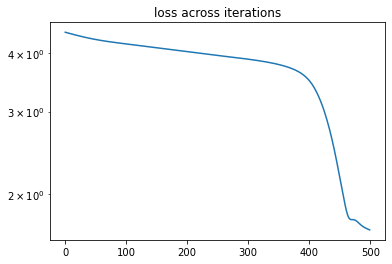

In [117]:
plt.semilogy(losses)
plt.title('loss across iterations')

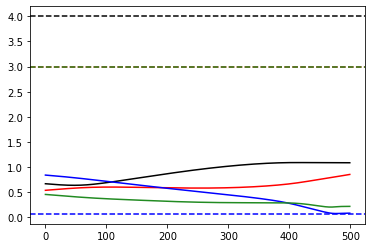

In [116]:
plt.figure()
plt.plot(param_vals['summation_field_sigma_factor'], color='r')
plt.axhline(y=3, color='r', linestyle='--')
plt.plot(param_vals['attention_field_gain'], color = 'k')
plt.axhline(y=4, color='k', linestyle='--')
plt.plot(param_vals['prf_sigma_scale_factor'], color= 'b')
plt.axhline(y=0.07, color='b', linestyle='--')
plt.plot(param_vals['suppressive_surround_sigma_factor'], color= 'forestgreen')
plt.axhline(y=3, color='forestgreen', linestyle='--');